# A class for module illumination
Klaus Jäger, 2 October 2019

With respect to v0.3, the angle definitions were altered such that they are compatible with the convention used in the papers. This version will be published together with the OpEx manuscript with the detailed illumination model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate
from scipy.integrate import quad
import time
from matplotlib import rc
from matplotlib.patches import Rectangle
import pysolar.solar as sol
import datetime
import timeit
%matplotlib inline

In [3]:
date = datetime.datetime(2019, 6, 20, 12, 0, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )

In [4]:
start = timeit.timeit()
for i in range(10):
    temp = sol.get_azimuth(52.5, 13.25, date)
end = timeit.timeit()
print(temp, end - start)

149.2367608365414 -0.001645835000090301


In [5]:
date = datetime.datetime(2019, 9, 23, 11, 0, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
print(sol.get_altitude(52.5, 13.25, date),sol.get_azimuth(52.5, 13.25, date))

31.874068541748763 144.11858303144155


/home/peter/anaconda3/envs/ds/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


### Preamble

In [6]:
# some useful functions
def fmod_pos(x,y):
    temp = np.fmod(x,y)
    if temp < 0.0:
        temp = temp + y
    return temp

def fmod_pos_array(x,y):
    temp = np.zeros(len(x))
    for i,xi in enumerate(x):
        temp[i] = fmod_pos(xi,y)
    return temp

def section(k_1,d_1,k_2,d_2): # intersection of two lines
    section_x = (d_1-d_2)/(k_2-k_1)
    section_y = k_1*section_x+d_1
    return (section_x,section_y)

def deg2rad(theta_deg):
    return theta_deg*np.pi/180.

def rad2deg(theta_rad):
    return theta_rad/np.pi*180.

### Class definition

In [7]:
class ModuleIllumination:
    def __init__(self, InputDict):
        self.input = InputDict
        self.variables()
        self.module()
        self.calc_irradiance_module_sky_direct()
        self.calc_irradiance_module_sky_diffuse()
        self.calc_radiance_ground_direct()
        self.calc_radiance_ground_diffuse()
        self.calc_module_ground_matrix()
        self.calc_irradiance_module_ground_direct()
        self.calc_irradiance_module_ground_diffuse()

    def variables(self): # Import all the variables 
        self.L = self.input['L']
        self.theta_m_rad = deg2rad(self.input['theta_m_deg'])
        self.H = self.input['H']
        self.D = self.input['D']
        self.DNI = self.input['DNI']
        self.DHI = self.input['DHI']
        self.theta_S_rad = deg2rad(self.input['theta_S_deg'])
        self.phi_S_rad = deg2rad(self.input['phi_S_deg'])
        self.albedo = self.input['albedo']
        self.ground_steps = self.input['ground_steps']
        self.module_steps = self.input['module_steps']
        self.angle_steps  = self.input['angle_steps']
        #Define variables derived from these base variables
        self.x_g_array = np.linspace(0,self.D,self.ground_steps)
        self.x_g_distance = self.D/(self.ground_steps-1) # distance between two points on x_g_array
        #self.l_array = np.linspace(0,self.L,self.module_steps) # OLD, changed on 26 April 2019!
        self.l_array = np.linspace(self.L/self.module_steps,self.L,self.module_steps)-0.5*self.L/self.module_steps
        # normal angle of the sun
        self.n_S = np.array([np.sin(self.theta_S_rad)*np.cos(-self.phi_S_rad),
                             np.sin(self.theta_S_rad)*np.sin(-self.phi_S_rad),
                             np.cos(self.theta_S_rad)])
        # initializing the results dictionary
        self.results = {}
        
    def module(self): # some functions and values for the PV module
        self.H_m = self.L*np.sin(self.theta_m_rad)
        self.e_m = np.array([np.cos(self.theta_m_rad),np.sin(self.theta_m_rad)]) # unit vector along the module
        self.n_m = np.array([-np.sin(self.theta_m_rad),np.cos(self.theta_m_rad)]) # normal to the module
        self.n_m_3D = np.array([self.n_m[0],0,self.n_m[1]]) # normal to the module
        
    # IRRADIANCE ON MODULE FROM THE SKY
    def calc_irradiance_module_sky_direct(self):
        temp_front = np.zeros(self.module_steps)
        temp_back  = np.zeros(self.module_steps)
        self.cos_alpha_mS = np.dot(self.n_S,self.n_m_3D) # cosine of angle between Sun and module normal
        angle_term = np.cos(self.theta_m_rad)-np.sin(self.theta_m_rad)*self.n_S[0]/self.n_S[2] # needed for calculating shadow on module
        if self.cos_alpha_mS > 0: #sunlight hits on front
            l_shadow = self.L-self.D/angle_term
            temp_front[l_shadow < self.l_array] = self.DNI*self.cos_alpha_mS # DMI = Direct Module Irradiance
        else: #sunlight hits on back
            l_shadow = self.L+self.D/angle_term
            temp_back[l_shadow < self.l_array] = self.DNI*np.abs(self.cos_alpha_mS) 
        self.results['irradiance_module_front_sky_direct'] = temp_front
        self.results['irradiance_module_back_sky_direct']  = temp_back
        self.results['irradiance_module_front_sky_direct_mean'] = np.mean(temp_front)
        self.results['irradiance_module_back_sky_direct_mean']  = np.mean(temp_back)
            
    def calc_irradiance_module_sky_diffuse(self):
        alpha_1 = -np.pi/2.0
        for fb in ['front','back']:
            field_name = 'irradiance_module_' + fb + '_sky_diffuse'
            temp = np.zeros(self.module_steps)
            for i,l in enumerate(self.l_array):
                if fb == 'front':
                    vector_2 = (self.L-l)*self.e_m - np.array([self.D,0])
                if fb == 'back':
                    vector_2 = (self.L-l)*self.e_m + np.array([self.D,0])
                alpha_2 = self.alpha(vector_2,fb)
                temp[i] = self.DHI * (np.sin(alpha_2)-np.sin(alpha_1))/2.0
            self.results[field_name] = temp
            self.results[field_name + '_mean'] = np.mean(temp)
            # Note that for the back the nomenclature in the OpEx manuscript differs:
            # epsilon_1 = - alpha_2
            # epsilon_2 = - alpha_1 = pi/2
        
    # RADIANCE OF THE GROUND
    # radiance of the ground originating from direct skylight
    def calc_radiance_ground_direct(self):
        self.irradiance_ground_direct_received = np.zeros(self.ground_steps)
        # x-coordinates of shadow: 
        s_A = -self.H/self.n_S[2]
        x_A = s_A * self.n_S[0]
        s_B = (-self.H-self.L*self.e_m[1])/self.n_S[2]
        x_B = self.L*self.e_m[0]+s_B * self.n_S[0]
        if x_B < x_A: # Sun from back
            x_A_new = x_B
            x_B_new = x_A
            x_A = x_A_new
            x_B = x_B_new
        length_shadow = x_B - x_A
        if length_shadow < self.D: # only in this case direct Sunlight will hit the ground
            x_A_red = fmod_pos(x_A,self.D) # reduce such that x_A_red is in [0,D]
            x_B_red = x_B - x_A + x_A_red          
            if x_B_red < self.D:
                for i,x in enumerate(self.x_g_array):
                    if (x < x_A_red) or (x > x_B_red): # Instead of  (x > x_B_red) in v0.1 (x > x_A_red)
                        self.irradiance_ground_direct_received[i] = self.DNI * np.cos(self.theta_S_rad)
            else:
                x_B_red = x_B_red - self.D # this was after the enumerate -> error!
                for i,x in enumerate(self.x_g_array):
                    if (x > x_B_red) and (x < x_A_red):
                        #print(x)
                        self.irradiance_ground_direct_received[i] = self.DNI * np.cos(self.theta_S_rad)
        self.results['radiance_ground_direct_emitted']  = self.irradiance_ground_direct_received / np.pi * self.albedo # division by pi converts irradiance into radiance assuming Lambertian scattering
    
    
    # functions for radiance of the ground originating from diffuse skylight  
    def a_i(self,i,x_g): # Vector between points (x_g,-H) and A_i (lower end of i'th module)
        return np.array([i*self.D,0])- np.array([x_g,-self.H])
    
    def b_i(self,i,x_g): # Vector between points (x_g,-H) and B_i (upper end of i'th module)
        return self.L*self.e_m + np.array([i*self.D,0])- np.array([x_g,-self.H])
    
    # radiance of the ground originating from diffuse skylight
    # this method leads to the same results as the one developped earlier (v0.1) but is much faster.
    def calc_radiance_ground_diffuse(self):
        self.irradiance_ground_diffuse_received = np.zeros(self.ground_steps)
        sin_zeta = np.zeros(4)
        sin_eta  = np.zeros(4)
        for i,x_g in enumerate(self.x_g_array):
            for j in range(4):
                a = self.a_i(j-1,x_g)
                b = self.b_i(j-1,x_g)
                sin_eta[j]  = a[0]/np.linalg.norm(a)
                sin_zeta[j] = b[0]/np.linalg.norm(b)
                
            #middle section:
            temp = min(sin_eta[2],sin_zeta[2])-sin_zeta[1]
            #front section
            if sin_zeta[0] < sin_eta[1]:
                temp = temp + sin_eta[1] - sin_zeta[0]
            # back section
            if max(sin_eta[2],sin_zeta[2]) < sin_zeta[3]:
                temp = temp + sin_zeta[3] - max(sin_eta[2],sin_zeta[2])

            self.irradiance_ground_diffuse_received[i] = 0.5*temp*self.DHI 
        self.results['radiance_ground_diffuse_emitted']  = self.irradiance_ground_diffuse_received / np.pi * self.albedo # division by pi converts irradiance into radiance assuming Lambertian scattering
       
    # IRRADIANCE ON MODULE FROM THE GROUND
    # some functions
    def alpha(self,vector,front_back): #calculate angle between n_m and vector for front and back sides
        if front_back == 'front':
            cos_alpha = np.dot(vector, self.n_m)/np.linalg.norm(vector)
        elif front_back == 'back':
            cos_alpha = np.dot(vector,-self.n_m)/np.linalg.norm(vector)
        else:
            print('ERROR! Value neither front nor back')
            cos_alpha = 1./0.
        sign_alpha = np.sign(self.n_m[0]*vector[1]-self.n_m[1]*vector[0])#sign such that vectors pointing below n_m positive
        return sign_alpha*np.arccos(cos_alpha)
    

    #calculate matrix that determines distribution of light from ground on the module
    def calc_module_ground_matrix(self):
        for fb in ['front','back']:
            intensity_matrix = np.zeros((self.module_steps, self.angle_steps, self.ground_steps))
            field_name = 'module_' + fb + '_ground_matrix'
            t = time.process_time()
            for i,l in enumerate(self.l_array): # remove 0th entry as otherwise the ray to calculate alpha1 would be parallel to x-axis!!!
                vector_2 = -l*self.e_m
                # position of the line starting at point on module via lowest pt. of module
                x_g_2 = l*self.e_m[0] - (l*self.e_m[1]+self.H)/vector_2[1]*vector_2[0]
                if fb == 'front':
                    vector_1 = np.array([-self.D,0])-l*self.e_m
                if fb == 'back':
                    vector_1 = np.array([ self.D,0])-l*self.e_m
                x_g_1 = l*self.e_m[0] - (l*self.e_m[1]+self.H)/vector_1[1]*vector_1[0]
                if fb == 'front':
                    lower_index = int(round(x_g_1/self.x_g_distance))
                    upper_index = int(round(x_g_2/self.x_g_distance))
                if fb == 'back':
                    lower_index = int(round(x_g_2/self.x_g_distance))+1 # 20191009 ensure that point ref. to lower_index > x_g_2: angle cannot be > 90 degrees
                    upper_index = int(round(x_g_1/self.x_g_distance))
                
                
                #index_array = np.arange(lower_index,upper_index+1) # changed on 20191009
                index_array = np.arange(lower_index,upper_index) # changed on 20191009
                x_g_array_full = self.x_g_distance*index_array
                alpha_array = np.zeros(len(index_array))
                #addend_array = np.zeros(len(index_array))
                for j,x_g in enumerate(x_g_array_full):
                    vector = np.array([x_g,-self.H])-l*self.e_m
                    alpha_array[j] = self.alpha(vector,fb)
                #if fb == 'front':
                #    print(alpha_array[-1]*180/np.pi)
                self.test = 0
                self.test2 = np.sin(alpha_array[-1]) - np.sin(alpha_array[0])
                self.upper = alpha_array[-1]
                self.lower = alpha_array[0]
                for j,x_g in enumerate(x_g_array_full):
                    if j == 0:
                        delta_alpha = 0.5*(alpha_array[1]-alpha_array[0])
                    elif j == len(index_array)-1:
                        delta_alpha = 0.5*(alpha_array[j]-alpha_array[j-1])
                    else:
                        delta_alpha = 0.5*(alpha_array[j+1]-alpha_array[j-1])
                    #print(np.mod(index_array[j],self.ground_steps))
                    cos_alpha = abs(np.cos(alpha_array[j]))
                    angle_index = np.int(np.floor(alpha_array[j]*self.angle_steps/np.pi+self.angle_steps/2.0))
                    if angle_index == self.angle_steps:
                        angle_index = angle_index-1
                    ground_index = np.mod(index_array[j],self.ground_steps)
                    self.test += abs(cos_alpha)*abs(delta_alpha)
                    intensity_matrix[i,angle_index,ground_index] += np.pi/2.0*cos_alpha*abs(delta_alpha)
            self.results[field_name] = intensity_matrix
            self.results[field_name + '_time'] = time.process_time()-t
    
    #irradiance on the module from the ground originating from direct skylight  
    def calc_irradiance_module_ground_direct(self): 
        for fb in ['front','back']:
            field_name = 'irradiance_module_' + fb + '_ground_direct'
            matrix = self.results['module_' + fb + '_ground_matrix']
            temp = np.sum(matrix, axis = 1)
            self.results[field_name] = (temp*self.results['radiance_ground_direct_emitted']).sum(axis=1)
            self.results[field_name + '_mean'] = np.mean(self.results[field_name])
            
    #irradiance on the module from the ground originating from diffuse skylight  
    def calc_irradiance_module_ground_diffuse(self): 
        for fb in ['front','back']:
            field_name = 'irradiance_module_' + fb + '_ground_diffuse'
            matrix = self.results['module_' + fb + '_ground_matrix']
            temp = np.sum(matrix, axis = 1)
            self.results[field_name] = (temp*self.results['radiance_ground_diffuse_emitted']).sum(axis=1)   
            self.results[field_name + '_mean'] = np.mean(self.results[field_name])

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb3f87a06a0>,
 <matplotlib.colorbar.Colorbar at 0x7fb3f46bb828>)

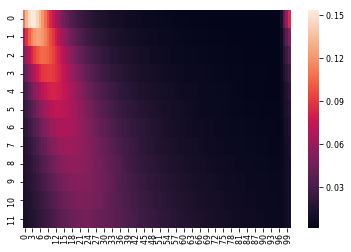

In [34]:
import seaborn as sns

sns.heatmap(GI_1238.results['module_back_ground_matrix'].sum(axis=1))

In [37]:
GI_1238.results['radiance_ground_direct_emitted']
GI_1238.theta_S_rad

0.5172620965539474

### Test the class

In [8]:
# Define the dictionary for the class
InputDict = {
    'L': 1.960,# module length, standard is 1650 mm or 1960 mm
    'theta_m_deg': 52., # Angle of the module with respect to the ground (first guess optimal theta_m = latitude on Earth)
    'D': 7.3, # distance between modules
    'H': 0.500, # height of module base above ground
    'DNI': 1, # direct normal irradiance
    'DHI': 1, # diffuse horizontal irradiance
    'theta_S_deg': 90-32.8, # zenith of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'phi_S_deg': 143.3, # azimuth of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'albedo': 0.3, # albedo of the ground
    'ground_steps': 101, #number of steps into which irradiance on the ground is evaluated in the interval [0,D]
    'module_steps': 12, # SET THIS NUMBER HIGHER FOR REAL EVALUATION! (SUGGESTION 20) number of lengths steps at which irradiance is evaluated on the module
    'angle_steps': 180 # Number at which angle discretization of ground light on module should be set
}

In [9]:
GI = ModuleIllumination(InputDict) # GroundIllumination

In [10]:
hour_range = np.linspace(4,21,18,dtype = int)
minute_range = np.linspace(0,50,6,dtype = int)
time_array = np.zeros(len(hour_range)*len(minute_range))
ground_direct = np.zeros([3,len(hour_range)*len(minute_range),InputDict['ground_steps']])
month_array = [6,8,11]

In [11]:
for k,month in enumerate(month_array):
    for i,hh in enumerate(hour_range):
        print(hh,'o clock')
        for j,mm in enumerate(minute_range):
            time_array[6*i+j] = hh + mm/60
            date_temp = datetime.datetime(2019, month, 20, hh, mm, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
            SunDict = {
                'theta_S_deg': 90 - sol.get_altitude(52.5, 13.25, date_temp),
                'phi_S_deg': sol.get_azimuth(52.5, 13.25, date_temp)
            }
            # Check if Sun is above the horizon
            if SunDict['theta_S_deg'] < 90:
                InputDict.update(SunDict)
                GI = ModuleIllumination(InputDict)
                ground_direct[k,i*6+j] = GI.irradiance_ground_direct_received

4 o clock
5 o clock
6 o clock
7 o clock
8 o clock
9 o clock
10 o clock
11 o clock
12 o clock
13 o clock
14 o clock
15 o clock
16 o clock
17 o clock
18 o clock
19 o clock
20 o clock
21 o clock
4 o clock
5 o clock
6 o clock
7 o clock
8 o clock
9 o clock
10 o clock
11 o clock
12 o clock
13 o clock
14 o clock
15 o clock
16 o clock
17 o clock
18 o clock
19 o clock
20 o clock
21 o clock
4 o clock
5 o clock
6 o clock
7 o clock
8 o clock
9 o clock
10 o clock
11 o clock
12 o clock
13 o clock
14 o clock
15 o clock
16 o clock
17 o clock
18 o clock
19 o clock
20 o clock
21 o clock


In [12]:
print(np.max(ground_direct))

0.8740905387358129


## Figures for OpEx

In [13]:
plt.rcParams['font.size'] = 8.0
#plt.rcParams['font.family'] = 'sans'
plt.rcParams['text.latex.preamble'] = r'\usepackage{arev}'
rc('text', usetex=True)

In [14]:
#x_ticks = np.linspace(0,100,6,dtype=int)
y_ticks = np.linspace(0,96,9,dtype=int)
x_ticks = [0,28,55,82]

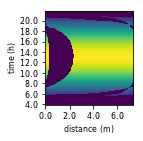

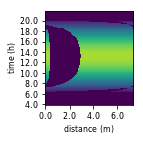

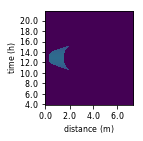

In [16]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(2,2))
    im = ax.imshow(ground_direct[i],origin='lower',vmax=0.88)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(np.round(GI.x_g_array[x_ticks],1))
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(time_array[y_ticks])
    ax.set_xlabel('distance (m)')
    ax.set_ylabel('time (h)')
    #if i==2:
    #    cbar = fig.colorbar(im, shrink =0.8, ax=ax)
    #    cbar.set_label('geom.\ dist.\ func.\ $\gamma_\mathrm{dir}$')
    figname = 'figures/ground_illum_{}.pdf'.format(i)
    plt.tight_layout()
    #plt.savefig(figname, format='pdf', dpi=300)
    plt.show()

In [17]:
print(GI.x_g_array[[0,28,55,82]])

[0.    2.044 4.015 5.986]


In [18]:
ground_direct = np.zeros([len(hour_range)*len(minute_range),InputDict['ground_steps']])
for i,hh in enumerate(hour_range):
    print(hh,'o clock')
    for j,mm in enumerate(minute_range):
        time_array[6*i+j] = hh + mm/60
        date_temp = datetime.datetime(2019, 11, 20, hh, mm, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=1)) )
        SunDict = {
            'theta_S_deg': 90 - sol.get_altitude(52.5, 13.25, date_temp),
            'phi_S_deg': sol.get_azimuth(52.5, 13.25, date_temp)
        }
        # Check if Sun is above the horizon
        if SunDict['theta_S_deg'] < 90:
            InputDict.update(SunDict)
            GI = ModuleIllumination(InputDict)
            ground_direct[i*6+j] = GI.irradiance_ground_direct_received

4 o clock
5 o clock
6 o clock
7 o clock


/home/peter/anaconda3/envs/ds/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


8 o clock
9 o clock
10 o clock
11 o clock
12 o clock
13 o clock
14 o clock
15 o clock
16 o clock
17 o clock
18 o clock
19 o clock
20 o clock
21 o clock


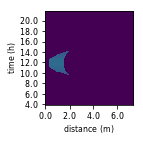

In [19]:
fig, ax = plt.subplots(figsize=(2,2))
im = ax.imshow(ground_direct,origin='lower',vmax=0.88)
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.round(GI.x_g_array[x_ticks],1))
ax.set_yticks(y_ticks)
ax.set_yticklabels(time_array[y_ticks])
ax.set_xlabel('distance (m)')
ax.set_ylabel('time (h)')
#cbar = fig.colorbar(im, ax=ax, shrink=0.9)
#cbar.set_label('geom.\ dist.\ func.\ $\gamma_\mathrm{dir}$')
#figname = 'figures/ground_illum_equ_cbar.pdf'.format(i)
figname = 'figures/ground_illum_2.pdf'.format(i)
plt.tight_layout()
#plt.savefig(figname, format='pdf', dpi=300)

plt.show()

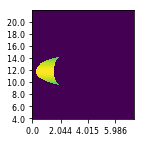

In [20]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(ground_direct,origin='lower')
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.round(GI.x_g_array[x_ticks],9))
ax.set_yticks(y_ticks)
ax.set_yticklabels(time_array[y_ticks])
plt.show()

In [21]:
ground_direct = np.zeros([len(hour_range)*len(minute_range),InputDict['ground_steps']])
for i,hh in enumerate(hour_range):
    print(hh,'o clock')
    for j,mm in enumerate(minute_range):
        time_array[6*i+j] = hh + mm/60
        date_temp = datetime.datetime(2019, 11, 12, hh, mm, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
        SunDict = {
            'theta_S_deg': 90 - sol.get_altitude(52.5, 13.25, date_temp),
            'phi_S_deg': sol.get_azimuth(52.5, 13.25, date_temp)
        }
        # Check if Sun is above the horizon
        if SunDict['theta_S_deg'] < 90:
            InputDict.update(SunDict)
            GI = ModuleIllumination(InputDict)
            ground_direct[i*6+j] = GI.irradiance_ground_direct_received

4 o clock
5 o clock
6 o clock
7 o clock
8 o clock
9 o clock
10 o clock
11 o clock
12 o clock
13 o clock
14 o clock
15 o clock
16 o clock
17 o clock
18 o clock
19 o clock
20 o clock
21 o clock


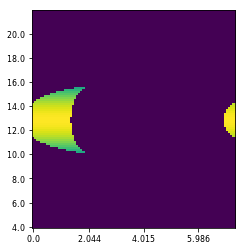

In [22]:
fig, ax = plt.subplots()
ax.imshow(ground_direct,origin='lower')
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.round(GI.x_g_array[x_ticks],9))
ax.set_yticks(y_ticks)
ax.set_yticklabels(time_array[y_ticks])
plt.show()

In [23]:
hour_range = np.linspace(4,21,18,dtype = int)
minute_range = np.linspace(0,50,6,dtype = int)
time_array = np.zeros(len(hour_range)*len(minute_range))
irradiance_ground_direct_received_array = np.zeros([len(hour_range)*len(minute_range),InputDict['ground_steps']])
for i,hh in enumerate(hour_range):
    for j,mm in enumerate(minute_range):
        time_array[6*i+j] = hh+mm/60
        date_temp = datetime.datetime(2019, 6, 21, hh, mm, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
        SunDict = {
            'theta_S_deg': 90 - sol.get_altitude(52.5, 13.25, date_temp),
            'phi_S_deg': sol.get_azimuth(52.5, 13.25, date_temp)
        }
        print(hh,mm,sol.get_altitude(52.5, 13.25, date_temp),sol.get_azimuth(52.5, 13.25, date_temp))

4 0 -5.395348898387416 38.81042856461801
4 10 -4.420235061915385 40.893875277034994
4 20 -3.4035249345652145 42.954433424373065
4 30 -2.3469811697632785 44.99257337150155
4 40 -1.2523627539601943 47.00892624916116
4 50 0.3722413137147543 49.00427348948375
5 0 1.3969628068710347 50.97953888835218
5 10 2.505562253541011 52.935780388123234
5 20 3.6770266811180194 54.87418273615887
5 30 4.8966795600875175 56.796051048161445
5 40 6.155579707805559 58.70280527051514
5 50 7.4479872405461505 60.59597655501858
6 0 8.769880137929132 62.477202814347294
6 10 10.118189750042474 64.3482287652587
6 20 11.490400710883044 66.21090415058286
6 30 12.884334837629515 68.06718540618
6 40 14.298027708001625 69.91913802847347
6 50 15.729654654865373 71.76894057646594
7 0 17.17748382611561 73.61889023839731
7 10 18.63984444465915 75.47140987554921
7 20 20.115104518301276 77.32905748999094
7 30 21.601652126317514 79.19453541503194
7 40 23.09788215806588 81.07070441591846
7 50 24.602182185785175 82.9605965080329

### Other figures for publications (OpEx)
Figures made on 20191111 and 20191112.

In [24]:
colors = ['#1f77b4','#ff7f0e','#396686','#c28249']
LightGrey = '#AAAAAA'
LightestGrey = '#EEEEEE'
DarkBlue = '#2D2F92'

In [25]:
plt.rcParams['font.size'] = 8.0
#plt.rcParams['font.family'] = 'sans'
plt.rcParams['text.latex.preamble'] = r'\usepackage{arev}'
rc('text', usetex=True)

In [26]:
date = datetime.datetime(2019, 6, 20, 11, 52, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
# Define the dictionary for the class
InputDict = {
    'L': 1.960,# module length, standard is 1650 mm or 1960 mm
    'theta_m_deg': 52., # Angle of the module with respect to the ground (first guess optimal theta_m = latitude on Earth)
    'D': 7.3, # distance between modules
    'H': 0.500, # height of module base above ground
    'DNI': 0, # direct normal irradiance
    'DHI': 440, # diffuse horizontal irradiance
    'theta_S_deg': 90-sol.get_altitude(52.5, 13.25, date), # zenith of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'phi_S_deg': sol.get_azimuth(52.5, 13.25, date), # azimuth of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'albedo': 0.3, # albedo of the ground
    'ground_steps': 101, #number of steps into which irradiance on the ground is evaluated in the interval [0,D]
    'module_steps': 12, # SET THIS NUMBER HIGHER FOR REAL EVALUATION! (SUGGESTION 20) number of lengths steps at which irradiance is evaluated on the module
    'angle_steps': 180 # Number at which angle discretization of ground light on module should be set
}
GI_1152 = ModuleIllumination(InputDict)

In [27]:
date = datetime.datetime(2019, 6, 20, 12, 38, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
# Define the dictionary for the class
InputDict = {
    'L': 1.960,# module length, standard is 1650 mm or 1960 mm
    'theta_m_deg': 52., # Angle of the module with respect to the ground (first guess optimal theta_m = latitude on Earth)
    'D': 7.3, # distance between modules
    'H': 0.500, # height of module base above ground
    'DNI': 883, # direct normal irradiance
    'DHI': 134, # diffuse horizontal irradiance
    'theta_S_deg': 90-sol.get_altitude(52.5, 13.25, date), # zenith of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'phi_S_deg': sol.get_azimuth(52.5, 13.25, date), # azimuth of the Sun (Berlin, 2019-09-20, 11:00 CEST)
    'albedo': 0.3, # albedo of the ground
    'ground_steps': 101, #number of steps into which irradiance on the ground is evaluated in the interval [0,D]
    'module_steps': 12, # SET THIS NUMBER HIGHER FOR REAL EVALUATION! (SUGGESTION 20) number of lengths steps at which irradiance is evaluated on the module
    'angle_steps': 180 # Number at which angle discretization of ground light on module should be set
}
GI_1238 = ModuleIllumination(InputDict)

In [28]:
irr_f = np.zeros([2,len(GI_1152.l_array)])
irr_b = np.zeros([2,len(GI_1152.l_array)])
for i,sg in enumerate(['sky','ground']):
    for k,dd in enumerate(['diffuse','direct']):
        irr_f[0] += GI_1152.results['irradiance_module_front_'+sg+'_'+dd]
        irr_b[0] += GI_1152.results['irradiance_module_back_'+sg+'_'+dd]
        irr_f[1] += GI_1238.results['irradiance_module_front_'+sg+'_'+dd]
        irr_b[1] += GI_1238.results['irradiance_module_back_'+sg+'_'+dd]
irr_t = irr_f + irr_b

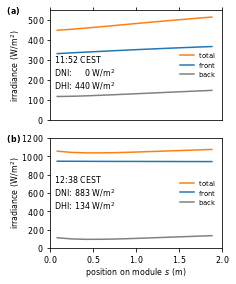

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(3.375, 4))
for i in range(2):
    if i == 0:
        ax = ax1
        subfig = r'\textbf{(a)}'
    else:
        ax = ax2
        subfig = r'\textbf{(b)}'
    ax.plot(GI_1152.l_array,irr_t[i],'-',label='total',color = colors[1])
    ax.plot(GI_1152.l_array,irr_f[i],'-',label='front',color = colors[0]) #, mfc = insidecolor)
    ax.plot(GI_1152.l_array,irr_b[i],'-',label='back',color = 'grey')
    ax.legend(frameon=False,fontsize=7)
    if i == 0:
        ymax = 550
        ax.set_ylim(0,ymax)
        ax.text(-.5,.97*ymax,r'\textbf{(a)}')
        ax.text(.05,.53*ymax,'11:52 CEST')
        ax.text(.05,.41*ymax,'DNI: \phantom{00}0 W/m$^2$')
        ax.text(.05,.29*ymax,'DHI: 440 W/m$^2$')
        ax.xaxis.tick_top()
        ax.set_xticklabels([])
    else:
        ymax = 1200
        ax.set_ylim(0,ymax)
        ax.text(-.5,.97*ymax,r'\textbf{(b)}')
        ax.text(.05,.6*ymax,'12:38 CEST')
        ax.text(.05,.48*ymax,'DNI: 883 W/m$^2$')
        ax.text(.05,.36*ymax,'DHI: 134 W/m$^2$')
        ax.set_xlabel('position on module $s$ (m)')

   
    ax.set_ylabel('irradiance (W/m$^2$)')
    
    ax.set_xlim(0,2)
fig.align_ylabels()
figname = 'figures/irradiance_module_example.pdf'
plt.tight_layout()
#plt.savefig(figname, format='pdf', dpi=300)
plt.show()

In [31]:
print('11:52 front: ', GI_1152.l_array[np.argmin(irr_f[0])])
print('11:52 bifac: ', GI_1152.l_array[np.argmin(irr_t[0])])
print('12:38 front: ', GI_1152.l_array[np.argmin(irr_f[1])])
print('12:38 bifac: ', GI_1152.l_array[np.argmin(irr_t[1])])

11:52 front:  0.08166666666666667
11:52 bifac:  0.08166666666666667
12:38 front:  1.8783333333333334
12:38 bifac:  0.5716666666666667


In [32]:
print(GI_1238.results['irradiance_module_back_ground_direct'])
print(GI_1238.results['irradiance_module_back_ground_diffuse'])

[73.98962513 61.44731639 55.99111454 55.54509409 57.16474755 60.40384247
 64.57141883 69.18829496 73.91528536 78.59663191 83.07397423 87.50891049]
[18.42177269 18.15011738 18.16199276 18.36542538 18.60057221 18.84924853
 19.08680886 19.29642049 19.46960068 19.61420761 19.6962355  19.71566271]


### Other figures

In [40]:
date = datetime.datetime(2019, 6, 20, 11, 52, 0, 0, tzinfo = datetime.timezone(datetime.timedelta(hours=2)) )
# Define the dictionary for the class
InputDict = {
    'L': 1.960,# module length, standard is 1650 mm or 1960 mm
    'theta_m_deg': 52., # Angle of the module with respect to the ground (first guess optimal theta_m = latitude on Earth)
    'D': 7.3, # distance between modules
    'H': 0.500, # height of module base above ground
    'DNI': 1, # direct normal irradiance
    'DHI': 1, # diffuse horizontal irradiance
    'theta_S_deg': 90-sol.get_altitude(52.5, 13.25, date), # zenith of the Sun
    'phi_S_deg': sol.get_azimuth(52.5, 13.25, date), # azimuth of the Sun
    'albedo': 0.3, # albedo of the ground
    'ground_steps': 101, #number of steps into which irradiance on the ground is evaluated in the interval [0,D]
    'module_steps': 12, # SET THIS NUMBER HIGHER FOR REAL EVALUATION! (SUGGESTION 20) number of lengths steps at which irradiance is evaluated on the module
    'angle_steps': 180 # Number at which angle discretization of ground light on module should be set
}

In [41]:
GI = ModuleIllumination(InputDict)

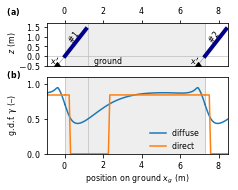

In [42]:
# PARAMETERS OF THE MODULE LINE
d = InputDict['D']
l = InputDict['L']
h = InputDict['H']
theta_m = InputDict['theta_m_deg']
k_m = np.tan(theta_m*np.pi/180.)
d_m = 0.0


#mod_func = k_m*fmod_pos_array(GI.x_g_array,d)
mod_func = k_m*GI.x_g_array
#y_m_plot2 = y_m_plot
h_mod = l*np.sin(theta_m*np.pi/180.)
w_mod = l*np.cos(theta_m*np.pi/180.)
#for i,y_i in enumerate(y_m_plot2):
#    if y_i > h_m:
#        y_m_plot2[i] = 1/0 #-h-1

id_mod = np.where(mod_func <= h_mod)
id_mod = id_mod[0][:-1] # remove last element


x_mod_array = GI.x_g_array[id_mod]
y_mod_array = mod_func[id_mod]
#for i,y_i in enumerate(mod_func):
#    if y_i > h_mod:
#        y_m_plot2[i] = -h

        
irr_ground_diff = GI.results['radiance_ground_diffuse_emitted'] * np.pi/GI.albedo

x_shadow = -h/np.tan(theta_m*np.pi/180.)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.375, 2.7))

# AXIS 1
ax1.add_patch(Rectangle((0, -h), d, h+h_mod+.2, color = LightestGrey))
ax1.axhline(0,color = LightGrey,linewidth = 0.5) 
for i,x_off in enumerate([0,d]): #x_off ... x offset
    ax1.axvline(x_off,color = LightGrey,linewidth = 0.5) 
    ax1.axvline(w_mod+x_off,color = LightGrey,linewidth = 0.5)    
    ax1.plot(np.array([x_shadow,0])+x_off,[-h,0],linewidth = 0.5, color='Grey')
    ax1.plot(x_mod_array+x_off,y_mod_array,linewidth = 4, color='DarkBlue')
    ax1.plot(x_shadow+x_off,-h,'d',color='k')
    ax1.text(0.07+x_off,1.0,'\#{}'.format(i+1),rotation = theta_m)
    ax1.text(x_shadow+x_off,-h+0.1,'$x\'$',horizontalalignment='right')
#ax1.text(-.85,1.4,r'\textbf{(a)}')
ax1.text(-3,2.2,r'\textbf{(a)}')
ax1.text(w_mod+.3,-h+.1,'ground')
ax1.xaxis.tick_top()
ax1.set_ylabel('$z$ (m)')
ax1.set_xlim(-0.95,8.5)
ax1.set_ylim(-.5,h_mod+.2)
ax1.set_yticks(np.linspace(-.5,1.5,5))
ax1.set_aspect('equal')

# AXIS 2
ax2.add_patch(Rectangle((0, 0), d, 1.1, color = LightestGrey))
for i,x_off in enumerate([-d,0,d]):
    ax2.axvline(d+x_off,color = LightGrey,linewidth = 0.5)
    ax2.axvline(w_mod+x_off,color = LightGrey,linewidth = 0.5)
    ax2.plot(GI.x_g_array+x_off,GI.irradiance_ground_diffuse_received,'-',color = colors[0],label=['','diffuse',''][i])
    ax2.plot(GI.x_g_array+x_off,GI.irradiance_ground_direct_received,'-',color = colors[1],label=['','direct',''][i])

ax2.set_xlabel('position on ground $x_g$ (m)')
ax2.set_ylabel('g.d.f.\ $\gamma$ (--)')
ax2.legend(loc=(.55,0),frameon=False,facecolor = 'w')
#ax2.text(-.85,0.8,r'\textbf{(b)}')
ax2.text(-3,1.1,r'\textbf{(b)}')
ax2.set_xlim(-0.95,8.5)
ax2.set_ylim(0.,1.1)

fig.subplots_adjust(hspace=-.5)
fig.align_ylabels()
figname = 'figures/irradiance_ground_OpEx.pdf'
plt.tight_layout()
#plt.savefig(figname, format='pdf', dpi=300)

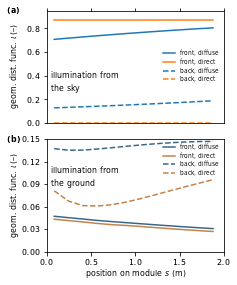

In [74]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(3.375, 4))
for i,sg in enumerate(['sky','ground']):
    if i == 0:
        ax = ax1
        subfig = r'\textbf{(a)}'
    else:
        ax = ax2
        subfig = r'\textbf{(b)}'
    for fb in ['front','back']:

        for k,dd in enumerate(['diffuse','direct']):
            k += 2*i
            if fb == 'front':
                linestyle = '-'
            else:
                linestyle= '--'

            ax.plot(GI.l_array,GI.results['irradiance_module_'+fb+'_'+sg+'_'+dd],linestyle,label=fb+', '+dd,color = colors[k]) #, mfc = insidecolor)
    ax.legend(frameon=False,fontsize=6)
    if i == 0:
        
        ax.set_ylim(0,.95)
        ax.text(-.45,0.97*.95,r'\textbf{(a)}')
        ax.text(.05,.4*.95,'illumination from')
        ax.text(.05,.28*.95,'the sky')
        ax.xaxis.tick_top()
        ax.set_xticklabels([])
    else:
        ax.set_ylim(0,0.15)
        ax.text(-.45,0.97*.15,r'\textbf{(b)}')
        ax.text(.05,.94*.112,'illumination from')
        ax.text(.05,.78*.112,'the ground')
        ax.set_xlabel('position on module $s$ (m)')
        ax.set_yticks(np.linspace(0,.15,6))
    #ax.set_title(subfig+' illumination from the '+sg)
   
    ax.set_ylabel('geom.\ dist.\ func.\ $\iota$ (--)')
    
    ax.set_xlim(0,2)
fig.align_ylabels()
figname = 'figures/irradiance_module_v4.pdf'
plt.tight_layout()
plt.savefig(figname, format='pdf', dpi=300)

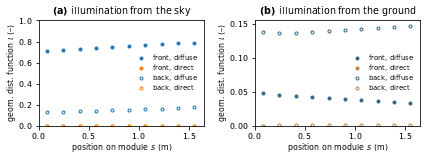

In [68]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6, 2.25))
for i,sg in enumerate(['sky','ground']):
    if i == 0:
        ax = ax1
        subfig = r'\textbf{(a)}'
    else:
        ax = ax2
        subfig = r'\textbf{(b)}'
    for fb in ['front','back']:

        for k,dd in enumerate(['diffuse','direct']):
            k += 2*i
            if fb == 'front':
                insidecolor = colors[k]
            else:
                insidecolor = '#ffffff'

            ax.plot(GI.l_array,GI.results['irradiance_module_'+fb+'_'+sg+'_'+dd],'.',label=fb+', '+dd,color = colors[k], mfc = insidecolor)
    ax.legend(frameon=False,fontsize=7)
    if i == 0:
        
        ax.set_ylim(0,1)
    else:
        ax.set_ylim(0,)
    ax.set_title(subfig+' illumination from the '+sg)
    ax.set_xlabel('position on module $s$ (m)')
    ax.set_ylabel('geom.\ dist.\ function $\iota$ (--)')
    ax.set_xlim(0,1.65)
figname = 'figures/irradiance_module.pdf'
plt.tight_layout()
plt.savefig(figname, format='pdf', dpi=300)



### Figures for illustration
The figures only can be plotted after the class was established.

In [ ]:
figure = plt.figure(figsize=(6,4))
plt.plot(GI.l_array,GI.results['irradiance_module_front_sky_direct'],label='front')
plt.plot(GI.l_array,GI.results['irradiance_module_back_sky_direct'],label='back')
plt.legend()
plt.title('Direct Illumination from the Sky')
plt.xlabel('position on module (m)')
plt.ylabel('Irradiance on module (m$^{-2}$) (DHI = 1)')

In [ ]:
#dict['theta_S_deg'] = 30 # zenith of the Sun
#dict['phi_S_deg'] = 135 # azimuth of the Sun
#GI = ModuleIllumination(dict) # GroundIllumination
figure = plt.figure(figsize=(6,4))
plt.plot(GI.x_g_array,GI.results['radiance_ground_diffuse_emitted'],label='diffuse ground')
plt.plot(GI.x_g_array,GI.results['radiance_ground_direct_emitted'],label='direct ground')
plt.legend()
#plt.title('Diffuse illumination from the sky')
plt.xlabel('position on ground (m)')
plt.ylabel('radiance from ground (m$^{-2}$) (DHI = 1)')

In [ ]:
figure = plt.figure(figsize=(6,4))
plt.plot(GI.l_array,GI.results['irradiance_module_front_ground_diffuse'],label='front, diffuse')
plt.plot(GI.l_array,GI.results['irradiance_module_front_ground_direct'],label='front, direct')
plt.plot(GI.l_array,GI.results['irradiance_module_back_ground_diffuse'],label='back, diffuse')
plt.plot(GI.l_array,GI.results['irradiance_module_back_ground_direct'],label='back, direct')
plt.legend()
plt.title('Illumination from the ground')
plt.xlabel('position on module (m)')
plt.ylabel('Irradiance on module (m$^{-2}$) (DHI = 1)')
figure = plt.figure(figsize=(6,4))
plt.plot(GI.l_array,GI.results['irradiance_module_front_sky_diffuse'],label='sky front')
plt.plot(GI.l_array,GI.results['irradiance_module_back_sky_diffuse'],label='sky back')
plt.legend()
plt.title('Diffuse illumination from the sky')
plt.xlabel('position on module (m)')
plt.ylabel('Irradiance on module (m$^{-2}$) (DHI = 1)')

In [ ]:
angle_matrix_front = GI.results['module_front_ground_matrix'].sum(axis=2)
angle_matrix_back = GI.results['module_back_ground_matrix'].sum(axis=2)

In [ ]:
figure = plt.figure(figsize=(12,8))
angle_array = np.linspace(-89.5,89.5,InputDict['angle_steps'])
for i,l in enumerate(GI.l_array):
    plt.plot(angle_array,angle_matrix_front[i,:],label = '{:0.0f} cm'.format(l*100))
plt.xlim(35,90)
plt.legend()
figure = plt.figure(figsize=(12,8))
for i,l in enumerate(GI.l_array):
    plt.plot(angle_array,angle_matrix_back[i,:],label = '{:0.0f} cm'.format(l*100))
plt.xlim(-40,90)
plt.legend()
    